# Dask streams

Module for real-time processing. It dynamically scales depending on the size of your system. Useful for continously generated/flowing data

- dynamic task scheduling
- real-time computation
- scalable distribution

Ideal for data pipelines/ETL, IoT data processing, financial market insights

## Other stream frameworks
- Kafka
- Spark streaming

## Create basic streams and push data to them

We need to use the [streamz library](https://streamz.readthedocs.io/en/latest/)

In [3]:
from streamz import Stream

/home/nsoler/.cache/pypoetry/virtualenvs/daskscratch-1ORGWtuD-py3.12/lib/python3.12/site-packages/streamz/plugins.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [4]:
source = Stream()

In [6]:
# We define a function to map to our stream
def increment(x):
    return x+1

In [8]:
# The map and sink methods both take a function and apply that function to every element in the stream. 
# The map method returns a new stream with the modified elements
# 'sink' is typically used at the end of a stream for final actions.
source.map(increment).sink(print)

'<sink: print>'

In [9]:
# To push data through our pipeline we call emit
data = (1,2,3)
for dat in data:
    source.emit(dat)

2
3
4


Accumulate allows you to track some state within the pipeline. It takes an accumulation function that takes the previous state, the new element, and then returns a new state and a new element to emit. In the following example we make an accumulator that keeps a running total of the elements seen so far.

In [18]:
# Computing a running total
def add(current,next_st):
    return current + next_st

# The accumulate function takes into account the previous state
source2 = Stream()
source2.accumulate(add).sink(print)

'<sink: print>'

In [14]:
data2 = (1,2,3)
for dat in data2:
    source2.emit(dat)

1
3
6


The accumulation function above is particularly simple, the state that we store and the value that we emit are the same. In more complex situations we might want to keep around different state than we emit. For example lets count the number of distinct elements that we have seen so far.

In [29]:
# Other example, monitoring if new numbers come out
def num_distinct(current:set, next_st):
    """
    The length of the set will not vary if an element 
    has already been seen
    """
    current.add(next_st)
    return current, len(current)

source3 = Stream()

# If we don't put returns_state, it returns the tuple from the function
source3.accumulate(num_distinct, start=set(), returns_state=True).sink(print)

'<sink: print>'

In [30]:
data3 = ('cat','dog','cat','fox')
for dat in data3:
    source3.emit(dat)

1
2
2
3


In [38]:
# Sliding window
source4= Stream()
source4.sliding_window(3,return_partial=False).sink(print)

'<sink: print>'

In [40]:
data = range(16)
for dat in data:
    source4.emit(dat)

(28, 29, 0)
(29, 0, 1)
(0, 1, 2)
(1, 2, 3)
(2, 3, 4)
(3, 4, 5)
(4, 5, 6)
(5, 6, 7)
(6, 7, 8)
(7, 8, 9)
(8, 9, 10)
(9, 10, 11)
(10, 11, 12)
(11, 12, 13)
(12, 13, 14)
(13, 14, 15)


## Branching and joining streams

In [44]:
# We define 2 functions for 2 streams
def increment(x):
    return x+1

def decrement(x):
    return x-1

In [56]:
source = Stream()

In [46]:
# Define 2 streams having the same source
stream1 = source.map(increment).sink(print)
stream2 = source.map(decrement).sink(print)

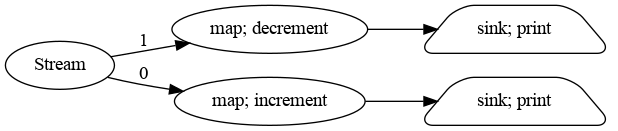

In [47]:
# Visualise (install networkx)
source.visualize(rankdir='LR')

In [49]:
# Emit some data and watch the output o
data = (1,10)
for dat in data:
    source.emit(dat)

2
0
11
9


### Combine the two branches

In [59]:
source = Stream() # reinitialize the source
stream1 = source.map(increment)
stream2 = source.map(decrement)

combined_stream = stream1.zip(stream2).map(sum).sink(print)

In [60]:
source.emit(10)

20


In [61]:
# use combine instead of Zip
# this is useful when streams operate at different speeds (from 2 independent sources)
source1 = Stream() 
source2 = Stream()

combined = source1.combine_latest(source2).sink(print)

In [62]:
source1.emit(10)
source2.emit(20)

(10, 20)


In [63]:
source2.emit(50)

(10, 50)
